# The 5 dimensions of human personality

### Project Outline 
* **1 - Dataset description**: In this part we give a first view about the project 


* **2 - Dataset exploration**: In this part we give the first insights about data
* **3 - Modelling Part 1**: About classification in Honest and Dishonest questionnaires
* **4 - Modelling Part 2**: Remove bias from Dishonest questionnaires for an unbiased selection of candidates: 
    * 4.1 - Treat task as regression
    * 4.2 - Treat task as classification
    * 4.3 - TF-IDF feature extraction + modelling
* **5 - Overall comparison of models**

## 1 - Dataset Description

### Purpose of the project
We want to investigate the way people can fake their responses into a questionnaire for obtaining a job or a specific role. In addition we want to model data making possible to detect liers and to remove the bias caused by the aim to appear  more suitable for the role.

### Data collection
In this experiment participants were required to respond to the same questionnaire twice. First, they were asked to respond honestly to all of its questions. Then, they were instructed them to fake their responses for a **role in a Humanitarian Organization**. We have the same subject responding in an honest condition and in one of instructed faking. Participants were asked to respond to the same set of 10 items twice, first honestly and then altering their answers to obtain a personal gain in the context described before. 

### Expectations
We expect the liers will give higher responses than truth-tellers because they have to appear in a better light and more suitable for the role.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from math import log10
warnings.filterwarnings('ignore')

In [2]:
# import and show dataframe
data = pd.read_csv('BF_df_CTU.csv')
n,p = data.shape # extract dimensions

print(f"We have {n//2} respondents that took questionnaire twice, in H (Honest) and D (Dishonest) condition")
data.head()

We have 221 respondents that took questionnaire twice, in H (Honest) and D (Dishonest) condition


,EX1G,EX2G,A1G,A2G,C1G,C2G,ES1G,ES2G,O1G,O2G,CONDITION
0,4,4,4,4,4,5,4,4,4,4,H
1,4,2,2,4,4,5,3,4,4,4,H
2,4,2,2,4,4,4,3,4,4,4,H
3,4,2,2,4,2,4,5,5,4,2,H
4,3,2,3,4,5,5,4,4,5,5,H


### Personalities

The scope of the questions is to infere the underlying "big 5" dimensions of personality, which are:

- EX = Extroversion scale
- A = Agreeableness scale
- C = Consciousness scale
- ES = Emotional stability scale 
- O = Openness scale

### Questions

For each dimension there are two specific questions, one positive correlated and one negative correlated. Those questions are:

I see myself as someone who ...
- **EX - EXTROVERSION**
    - is outgoing, sociable (extroversion);
    - is reserved (extroversion reversed);
- **A - AGREBLENESS**
    - tends to find fault with others (agreeableness, reversed);    
    - is generally trusting (agreeableness);
- **C - CONSCIOUSNESS**
    - tends to be lazy (consciousness, reversed)
    - does a thorough job (consciousness)
- **ES - EMOTIONAL STABILITY**
    - gets nervous easily (emotional stability, reversed);
    - is relaxed, handles stress well (emotional stability);
- **O - OPENESS**
    - has an active imagination (openness);
    - has few artistic interests (openness, reversed).

Each answer is given by an integer number from 1 to 5.


221 people filled the questionnaire twice, in a first palce  being honest and then faking it.

In [3]:
# divide data in Honest (H) and Dishonest (D)
x_real = data.iloc[:n//2,:-1]
x_fake = data.iloc[n//2:,:-1]

In [4]:
# randomly choose 80% train, 10% validation, 10% test set
np.random.seed(0) # make reults reproducible
index = np.random.choice([0,1,2], size=n//2, p=[0.8,0.1,0.1]) # sample random groups of indexes

x_real_smalltrain = x_real[index==0]
x_real_val = x_real[index==1]
x_real_test = x_real[index==2]

x_fake_smalltrain = x_fake[index==0]
x_fake_val = x_fake[index==1]
x_fake_test = x_fake[index==2]

# create a full train set (that contains validation data) for final model training before test part
x_real_train = x_real[index!=2]
x_fake_train = x_fake[index!=2]

## 2 - Dataset Exploration
In which way people are faking?

Here there is the plot of some examples, of true vs fake responses, of the same subject. It's important to have a first view about what's the respondent behaviour.



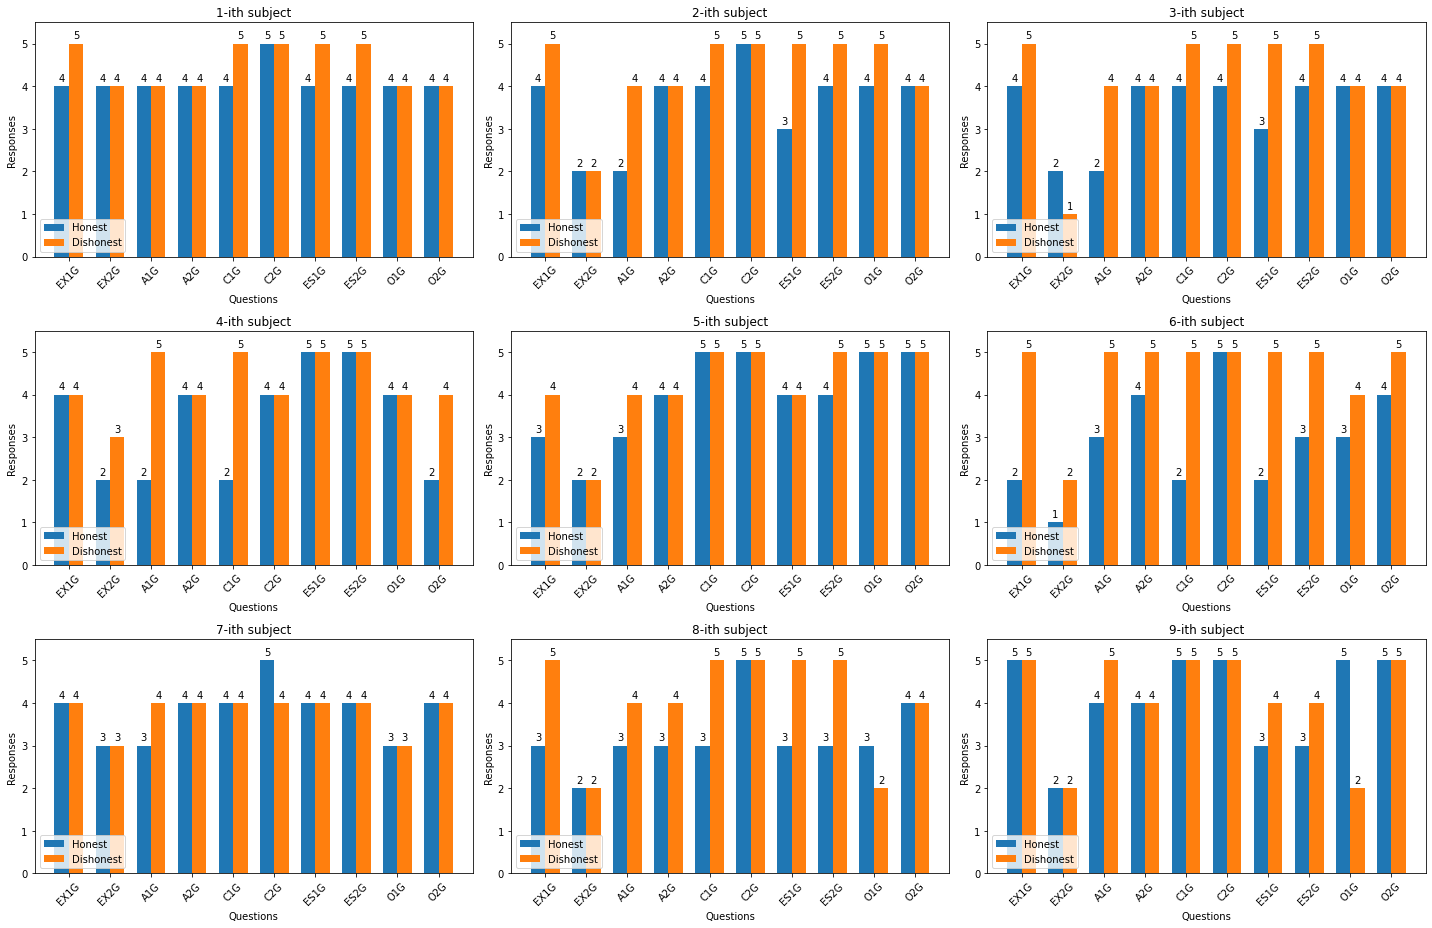

In [5]:
fig, ax = plt.subplots(3,3, figsize=(20, 13))

for i in range(9):

    row = int(i/3)
    col = i % 3

    labels = list(data.columns[:-1])

    honest = list(data.iloc[i,:-1])
    lier = list(data.iloc[n//2 + i,:-1])

    x = np.arange(len(labels))  
    width = 0.35  

    rects1 = ax[row, col].bar(x - width/2, honest, width, label='Honest')
    rects2 = ax[row, col].bar(x + width/2, lier, width, label='Dishonest')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[row, col].set_title(str(i+1) + "-ith subject")
    ax[row, col].set_ylabel('Responses')
    ax[row, col].set_xlabel('Questions')
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels(labels, rotation=45)
    ax[row, col].legend(bbox_to_anchor=(0,0), loc="lower left")
    ax[row, col].set_ylim([0,5.5])

    def autolabel(rects):
        """Attach a text label above each bar, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax[row, col].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

fig.tight_layout()

plt.show()

### Mean behavior
More than to see some examples, it is more interesting the typical behavior, so the mean across all subjects.

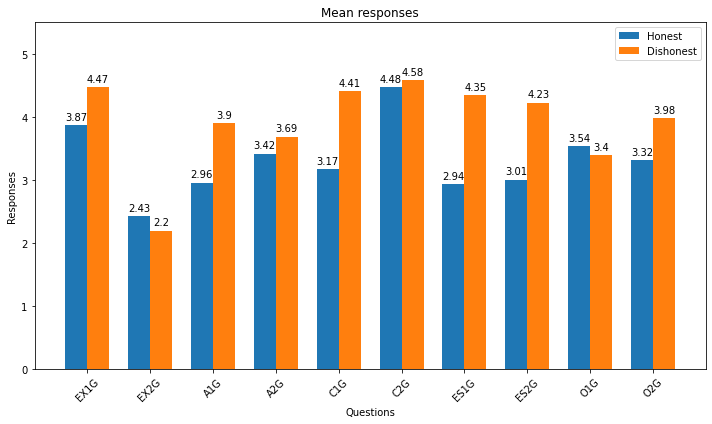

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

labels = list(data.columns[:-1])

honest = list(x_real.mean(0).round(2))
lier = list(x_fake.mean(0).round(2))

x = np.arange(len(labels))  
width = 0.35  

rects1 = ax.bar(x - width/2, honest, width, label='Honest')
rects2 = ax.bar(x + width/2, lier, width, label='Dishonest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title("Mean responses")
ax.set_ylabel('Responses')
ax.set_xlabel('Questions')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend(bbox_to_anchor=(1,1), loc="upper right")
ax.set_ylim([0,5.5])

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In most of the questions the honest have a lower mean. In particular dishonests tend to exaggerate their emotional stability, by lying the most on those questions. This make sense since they are trying to get the humanitarian role, where it is useful to be emotionally stable. This is an example of faking good.

## 3 - Modelling (part 1)
### Classification of fake questionnaires
*Fake or honest?*

In this part of the project we try to find faked questionnaires looking at responses, we'll use an interpretable model such as a **sparse** version of **regularized logistic regression**. In this way we can get insights about what are the responses that more discriminates between Honest and Dishonest. 

In [7]:
# create target and explanatory variables
y = np.array([1 if c == "D" else 0 for c in data["CONDITION"]]) # create response array
X = data.iloc[:,:-1].copy() # make a copy of dataset removing last column

In [8]:
# split train and test data for good evaluation of the model, test size 10% of total 442 samples
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
# fit logistic regression with est regularization parameters on train set
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(random_state=124, verbose=False, penalty="l1", solver="saga", max_iter=3000, C = 0.1)
_ = LR.fit(X_train, y_train)

In [10]:
# make predictions and calculate accuracy score of classification
from sklearn.metrics import accuracy_score

y_hat = LR.predict(X_test)
print(f"Accuracy of regularized logistic regression: {accuracy_score(y_hat, y_test).round(2)}" ) 
print(f"There were {sum(y_hat != y_test)} errors on {len(y_test)} predictions")


Accuracy of regularized logistic regression: 0.91
There were 4 errors on 45 predictions


Since the accuracy is high on the test set, we don't try more complex models but we prefer to investigate more model interpretation and why some questionnaires are classified in a wrong way.

### Interpretation
The high accuracy on the test set ensures that the model behaviour is good for our pourpuses, but it's not the only thing we care about. In fact we need to inspect what are the most faked responses in order to appear on a better light fot the **role in Humanitarian Organization**.

The following plot, named *coefficient plot*, helps us to understand what are the most faked questions and how the model coefficients are significative.


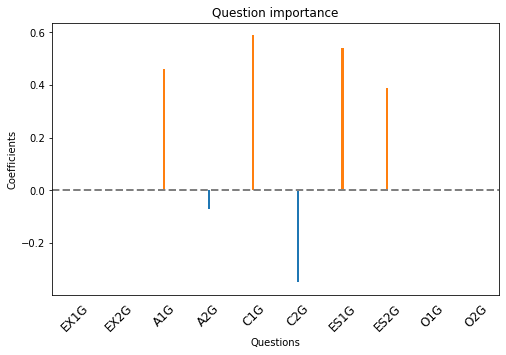

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

coef_df = pd.DataFrame({"varname" : list(data.columns)[:-1],
                        "coef" : LR.coef_.round(2)[0]})

coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', legend=False)
ax.set_xlabel('Questions')
ax.set_ylabel('Coefficients')
ax.set_title("Question importance")
ax.axhline(y=0, linestyle='--', color='gray', linewidth=2)

ax.bar(x=np.arange(coef_df.shape[0]), width=0.05,
           height=coef_df['coef'], color=["tab:blue" if c < 0 else "tab:green" if c == 0 else "tab:orange" for c in coef_df['coef']])

ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(list(data.columns)[:-1], 
                       rotation=45, fontsize=12)



As we can see the model does not consider EX (Extrovertion) and O (Opensess) for discriminating between honests and liers. C and ES seem to be the questions where the liers tend to fake more. A is also faked, in particular the "*tends to find fault with others*" question.

The model confirmed what was seen on the exploratory analysis, and said something more on the other questions

### What are the wrong predictions?

Before moving to the faking removal modelling, it's important to check what kind of errors the model is doing.

In [12]:
# print misclassified examples

print("Misclassifications:")
errors = X_test.join(data["CONDITION"]).join(pd.Series(["D" if c == "H" else "H" for c in data["CONDITION"]], name="Prediction")).iloc[y_hat != y_test,:]
errors

Misclassifications:


,EX1G,EX2G,A1G,A2G,C1G,C2G,ES1G,ES2G,O1G,O2G,CONDITION,Prediction
116,5,2,2,4,5,5,5,4,3,2,H,D
79,5,2,4,3,5,4,3,3,2,3,H,D
75,4,1,5,3,2,5,5,4,5,3,H,D
199,5,1,4,5,5,5,5,5,5,5,H,D


### Comparison between misclassifications and typical behavior

All the 4 errors are made by classifying one subject as lier, when it is not. So here there is the comparison between the misclassified subjects and the typical dishonest behavior, in order to see if the model have a good reason to classify them as liers.

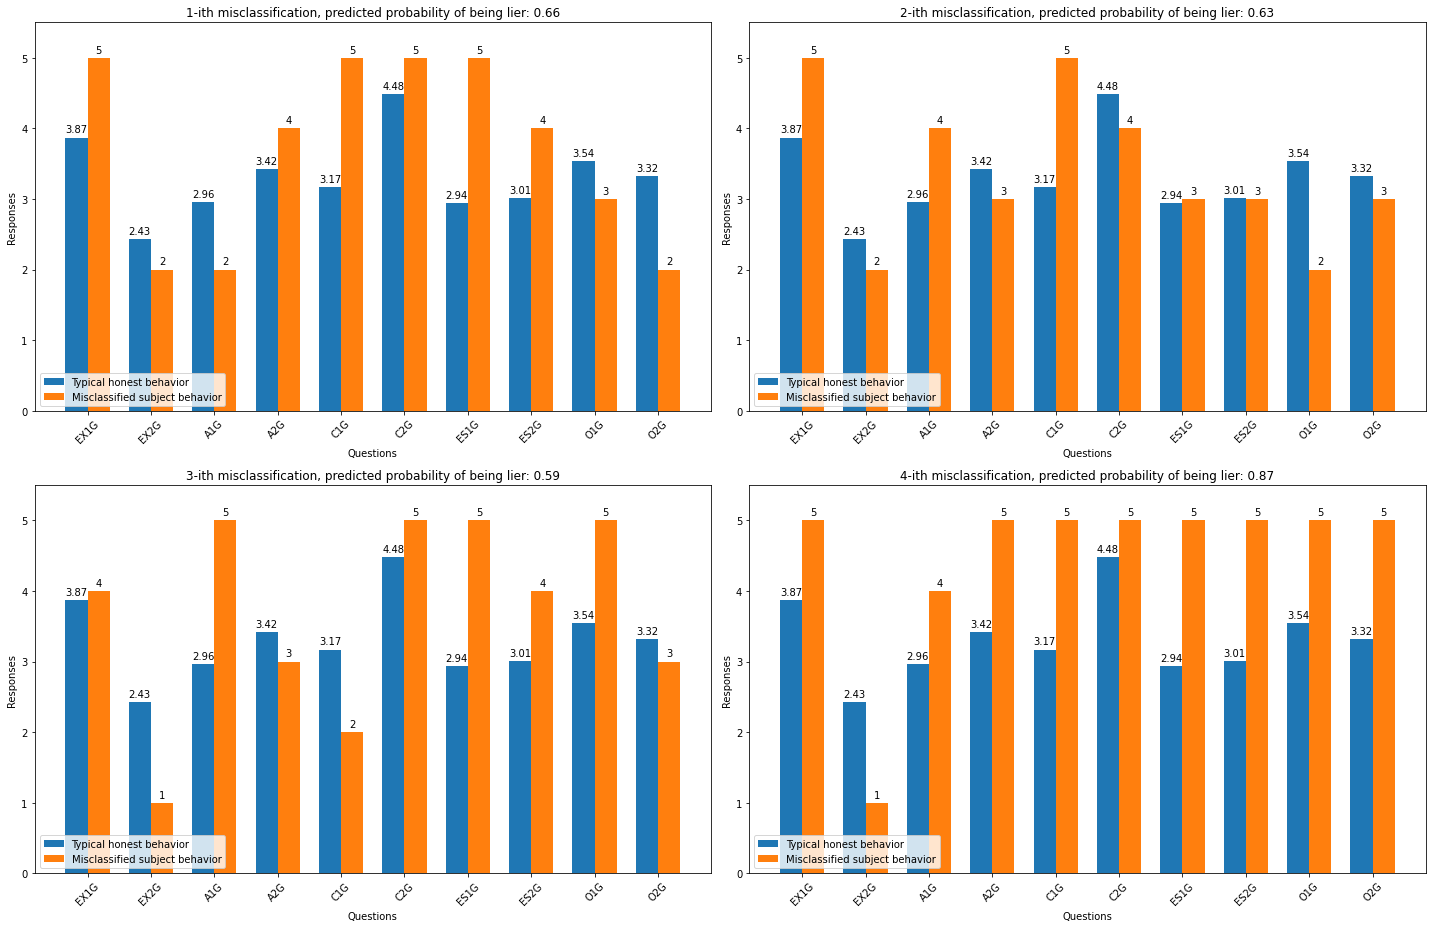

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(20, 13))

for i in range(4):

    row = int(i/2)
    col = i % 2

    labels = list(data.columns[:-1])

    honest = list(x_real.mean(0).round(2))
    errs = list(errors.iloc[i, :-2])

    x = np.arange(len(labels))  
    width = 0.35  

    rects1 = ax[row, col].bar(x - width/2, honest, width, label='Typical honest behavior')
    rects2 = ax[row, col].bar(x + width/2, errs, width, label='Misclassified subject behavior')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[row, col].set_title(str(i+1) + "-ith misclassification, predicted probability of being lier: " + 
                           str(LR.predict_proba(np.array(errs).reshape((1,-1))).round(2)[0,1])  )
    ax[row, col].set_ylabel('Responses')
    ax[row, col].set_xlabel('Questions')
    ax[row, col].set_xticks(x)
    ax[row, col].set_xticklabels(labels, rotation=45)
    ax[row, col].legend(bbox_to_anchor=(0,0), loc="lower left")
    ax[row, col].set_ylim([0,5.5])

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax[row, col].annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

fig.tight_layout()

plt.show()

The probability to be lier, assigned by the model, is near 50% for 3 examples. So they are not strong errors, but just examples where the model is not sure and gives the wrong answer. The only strong error, with 87% of probability assigned, make sense since the subject responded 5 out of 5 in 8 questions out of 10. So its behavior could be easily considered as not honest.

## 4 - Modelling (part 2)

### Adjust faked questionnaires to honest

We will compare different approaches for infering the honest responses given a faked questionnaire:
* Regression approach:

    - Naive approach (regression)
    - Denoising Autoencoder
    - Tree Based Regression
    - ElasticNet Regression

* Classification approach:

    - Naive classification
    - Classification Tree
    - Neural Networks for classification

* Classification and regression with TF-IDF:

    - Tree Based Regression TF-IDF
    - ElasticNet Regression TF-IDF
    - Classification Tree TF-IDF
    - Neural Networks for classification TF-IDF

## 4.1 - Task as a regression

### Naive regression approach

All the proposed method should outperform the trivial strategy of subtracting to each subject faked response the average of the difference, across all subjects, among faked and honest response.

In [69]:
# calculate the mean of the differences between faked and real response
mean_train = (x_fake_train.to_numpy() - x_real_train.to_numpy()).mean(axis=0)

# predict the real Test Set response subtractin the mean from the fake responses
x_real_test_predicted = x_fake_test.to_numpy() - mean_train

# calculate the MSE on Test Set
test_mse_naive_reg = ((x_real_test_predicted - x_real_test.to_numpy()) **2).mean()
test_mae_naive_reg = (abs(x_real_test_predicted - x_real_test.to_numpy())).mean()
print(f"Naive approach: \n MSE metric: {test_mse_naive_reg.round(3)} \n MAE metric: {test_mae_naive_reg.round(3)}")

Naive approach: 
 MSE metric: 1.286 
 MAE metric: 0.845


With this **basic approach**, that we'll usa as a baseline, we have a Mean Absolute Error of 0.84. 
This means that we are able to predict Honest responses with a mean error of 0.84 points for each response. 

### Denoising Autoencoder

We built and trained an undercomplete autoencoder which takes in input the fake questionnaires and try to reconstruct the real ones.

The goal of the autoencoder is to capture the important features present in the data. It has a small hidden layer if compared to Input Layer. This type of autoencoders do not need any regularization as they maximize the probability of data rather copying the input to output. One way to get useful features from the autoencoder is to constrain H to have a smaller dimension than x. For this reason is called undercomplete. Learning an undercomplete representation forces the autoencoder to capture the most salient features of the training data.

In [76]:
tf.random.set_seed(42)

dim_1 = 10
dim_2 = 7
dim_3 = 4

# the imput shape vector is composed by the 10 questions
input_vector = tf.keras.layers.Input(shape=(10,))

# define the encoder
hidden_1 = tf.keras.layers.Dense(dim_1, activation='sigmoid')(input_vector)
hidden_2 = tf.keras.layers.Dense(dim_2, activation='sigmoid')(hidden_1)
encoded = tf.keras.layers.Dense(dim_3, activation='sigmoid')(hidden_2)

# ...and the decoder...
hidden_3 = tf.keras.layers.Dense(dim_2, activation='sigmoid')(encoded)
decoded = tf.keras.layers.Dense(dim_1, activation='linear')(hidden_3)

# and finally the autoencoder
autoencoder = tf.keras.models.Model(inputs=input_vector, outputs=decoded)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=opt, loss='mse')

In [77]:
# we can show autoencoder structure
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
dense_245 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_246 (Dense)            (None, 7)                 77        
_________________________________________________________________
dense_247 (Dense)            (None, 4)                 32        
_________________________________________________________________
dense_248 (Dense)            (None, 7)                 35        
_________________________________________________________________
dense_249 (Dense)            (None, 10)                80        
Total params: 334
Trainable params: 334
Non-trainable params: 0
________________________________________________________

We can see that in layer number 4, the central one in the network, we have a low number of params. This for the reason described in autoencoder explanation above. Now we can fit the autoencoder on our training data.

In [78]:
# fit the denoising autoencoder
history = autoencoder.fit(x_fake_smalltrain, x_real_smalltrain, epochs=150, shuffle=True, validation_data=(x_fake_val, x_real_val),  verbose = False)

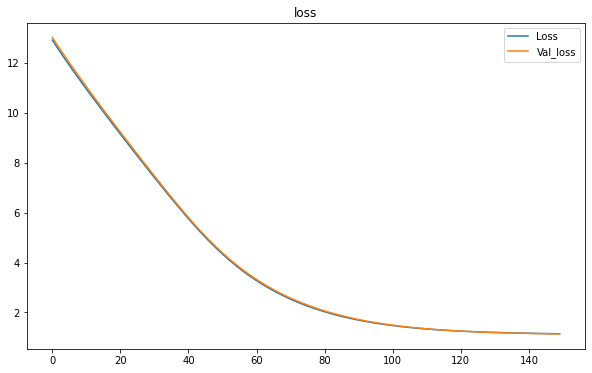

In [79]:
# plot loss and metrics 
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.legend(["Loss", "Val_loss"])
  plt.title('loss')
  
plot_loss(history)

We can be sure that the autoencoder is learning in the proper way looking at the plot of the losses during training. So in this plot we see that the autoencoder is learning how to take fake questionnaires and remove the faking good bias!

We can now make predictions on the test data:

In [80]:
# fit on entire train
_ = autoencoder.fit(x_fake_train, x_real_train, epochs=150,  verbose = False)

# make predictions
x_real_test_predicted = autoencoder.predict(x_fake_test)

In [81]:
# calculate the MSE and MAE on Test Set
test_mse_denoising_autoencoder = ((x_real_test_predicted.round(0) - x_real_test.to_numpy()) **2).mean()
test_mae_denoising_autoencoder = (abs(x_real_test_predicted.round(0) - x_real_test.to_numpy())).mean()
print(f"Denoising Autoencoder approach: \n MSE metric: {test_mse_denoising_autoencoder.round(3)} \n MAE metric: {test_mae_denoising_autoencoder.round(3)}")

Denoising Autoencoder approach: 
 MSE metric: 1.132 
 MAE metric: 0.826


With **Denoising Autoencoder** approach we lightly improve the baseline, from a MSE of 1.286 to 1.132. This means that this approach works better than the Naive one. 
### Gradient Boosting Regression

XGBoost is an ensemble learning method. Sometimes, it may not be sufficient to rely upon the results of just one machine learning model. Ensemble learning offers a systematic solution to combine the predictive power of multiple learners. The resultant is a single model which gives the aggregated output from several models. The models that form the ensemble could be either from the same learning algorithm or different learning algorithms. In XGBoost Bagging and Boosting techniques are used in combination with decision trees.

Decision tree is one of the most powerful and popular tool for classification and prediction. A Decision tree is a flowchart like tree structure, where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label.

In this modellin approach we need also to test different model structures for beaing sure to obtain the best possible result. For this reason we'll create a function to make a Grid Search for finding the best Hyperparameters for the XGBoost model.

In [82]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            if i == 1:
                return results['params'][candidate]
                
# select params to combine for finding optimal configuration
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

We need to predict one true response at time based on the ten faked responses of the faked questionnaire. 

For a more precise prediction we find the best model for each respond using the Grid Serach method. For this reason we preform a loop for finding the best Hyperparameters and fitting the model one time for each of the ten responses. Then we combine the different response predictions for a reconstructed unbiased questionnaire:

In [83]:
X_train = x_fake_train

X_test = x_fake_test
y_test = x_real_test
y_pred = pd.DataFrame(index=y_test.index)

# we need to fit one model for each q (question)
for q in range(p-1):

    print(f"Start with question {q+1}")

    # define the target question
    y_train = x_real_train.iloc[:,q]

    # define the model, random state for reproducibility
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

    # search for best configuration with cross validation
    search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=10, cv=3, verbose=0, n_jobs=1, return_train_score=True)
    search.fit(X_train, y_train)

    # best model found
    best_model_parameters = report_best_scores(search.cv_results_, 1)

    # fit best configuration model
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **best_model_parameters)
    xgb_model.fit(X_train, y_train)

    # predict and append the question
    y_column_pred = xgb_model.predict(X_test)
    y_pred = y_pred.join(pd.Series(y_column_pred, index=y_test.index, name=y_test.columns[q]))

Start with question 1
Start with question 2
Start with question 3
Start with question 4
Start with question 5
Start with question 6
Start with question 7
Start with question 8
Start with question 9
Start with question 10


In [84]:
# calculate the MSE and MAE on Test Set
test_mse_xgboost_reg = ((y_pred.to_numpy() - y_test.to_numpy()) **2).mean()
test_mae_xgboost_reg = (abs(y_pred.to_numpy() - y_test.to_numpy())).mean()
print(f"XGBoost regression approach: \n MSE metric: {test_mse_xgboost_reg.round(3)} \n MAE metric: {test_mae_xgboost_reg.round(3)}")

XGBoost regression approach: 
 MSE metric: 1.116 
 MAE metric: 0.768


With **Tree XGBRegressor** approach we lightly improve the Denoising Autoencoder approach. Especially in terms of MAE (Mean Absolute Error) metric. It means that this model performs a better reconstruction of non faked questionnaires starting from the faked ones.

### ElasticNet Regression

ElasticNet is a common model used in statitics for prediction pourposes. 

In the fitting of linear or logistic regression models, the elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods. Those mentioned methods use penalties for selecting the best explanatory variables among the possible ones. The final pourpose is to weight the different variables influence on target variable for the best possible prediction.

In [85]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings('ignore')

# grid search to tune the parameters:
parametersGrid = {"max_iter": [1,10,100,1000], "alpha": [0.001, 0.01, 0.1, 1],"l1_ratio": np.arange(0.0, 1.0, 0.1)}

We perform a loop with an approach similar to the previous XGBoost model, for finding the best Hyperparameters configuration for all models predictiong the single response. Than we can calculate the prediction metrics and compare them with the other models ones.


In [86]:
y_pred = pd.DataFrame(index=y_test.index)

# we need to fit one model for each q (question)
for q in range(p-1):

    print(f"Start with question {q+1}")

    # define the target question
    y_train = x_real_train.iloc[:,q]

    # define the model, random state for reproducibility
    eNet = ElasticNet(random_state=42)

    # search for best configuration with cross validation
    grid = GridSearchCV(eNet, parametersGrid, cv=5)
    grid.fit(X_train, y_train)

    # best model found
    best_model_parameters = report_best_scores(grid.cv_results_, 1)

    # fit best configuration model
    eNet = ElasticNet(random_state=42, **best_model_parameters)
    eNet.fit(X_train, y_train)

    # predict and append the question
    y_column_pred = eNet.predict(X_test)
    y_pred = y_pred.join(pd.Series(y_column_pred, index=y_test.index, name=y_test.columns[q]))

Start with question 1
Start with question 2
Start with question 3
Start with question 4
Start with question 5
Start with question 6
Start with question 7
Start with question 8
Start with question 9
Start with question 10


In [87]:
# calculate the MSE and MAE on Test Set
test_mse_elasticnet = ((y_pred.to_numpy() - y_test.to_numpy()) **2).mean()
test_mae_elasticnet = (abs(y_pred.to_numpy() - y_test.to_numpy())).mean()
print(f"ElasticNet regression approach: \n MSE metric: {test_mse_elasticnet.round(3)} \n MAE metric: {test_mae_elasticnet.round(3)}")

ElasticNet regression approach: 
 MSE metric: 1.054 
 MAE metric: 0.809


| Model | MSE | MAE |
| --- | --- | --- |
| Naive approach (regression) | 1.29 | 0.84 |
| Denoising Autoencoder | 1.13 | 0.83 |
| Gradient Boosting Regression | 1.12 | 0.77 |
| ElasticNet Regression | 1.05 | 0.81 |

So far the best model in term of MSE is the ElasticNet Regression!

## 4.2 - Task as classification

### Naive classification

In [91]:
# calculate the mean of the differences between faked and real response
mean_train = (x_fake_train.to_numpy() - x_real_train.to_numpy()).mean(axis=0)

# predict the real Test Set response subtractin the mean from the fake responses
x_real_test_predicted = x_fake_test.to_numpy() - mean_train

# calculate the MSE on Test Set
test_mse_naive_class = ((x_real_test_predicted.round(0) - x_real_test.to_numpy()) **2).mean()
test_mae_naive_class = (abs(x_real_test_predicted.round(0) - x_real_test.to_numpy())).mean()
print(f"Naive approach: \n MSE metric: {test_mse_naive_class.round(3)} \n MAE metric: {test_mae_naive_class.round(3)}")

Naive approach: 
 MSE metric: 1.374 
 MAE metric: 0.816


### Gradient Boosting Classification

In [92]:
X_train = x_fake_train

X_test = x_fake_test
y_test = x_real_test
y_pred = pd.DataFrame(index=y_test.index)

# we need to fit one model for each q (question)
for q in range(p-1):

    print(f"Start with question {q+1}")

    # define the target question
    y_train = x_real_train.iloc[:,q]

    # define the model, random state for reproducibility
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", num_parallel_tree = 3, eval_metric= "merror",  random_state=42)

    # search for best configuration with cross validation
    search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=10, cv=3, verbose=0, n_jobs=1, return_train_score=True)
    search.fit(X_train, y_train)

    # best model found
    best_model_parameters = report_best_scores(search.cv_results_, 1)

    # fit best configuration model
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, num_parallel_tree = 3,eval_metric= "merror",  **best_model_parameters)
    xgb_model.fit(X_train, y_train)

    # predict and append the question
    y_column_pred = xgb_model.predict(X_test)
    y_pred = y_pred.join(pd.Series(y_column_pred, index=y_test.index, name=y_test.columns[q]))

Start with question 1
Start with question 2
Start with question 3
Start with question 4
Start with question 5
Start with question 6
Start with question 7
Start with question 8
Start with question 9
Start with question 10


In [93]:
# calculate the MSE and MAE on Test Set
test_mse_xgboost_class = ((y_pred.to_numpy()- y_test.to_numpy()) **2).mean()
test_mae_xgboost_class = (abs(y_pred.to_numpy()- y_test.to_numpy())).mean()
print(f"XGBoost classification approach: \n MSE metric: {test_mse_xgboost_class.round(3)} \n MAE metric: {test_mae_xgboost_class.round(3)}")

XGBoost classification approach: 
 MSE metric: 1.647 
 MAE metric: 0.9


### Neural Network for classification

Let's now train 10 Neural Networks, each of which take in input the fake survey and try to recunstruct in output the probability distribution over the possible 5 labels of a particular question of the real survey.

In [23]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [94]:
# encoding of data

x_real_smalltrain_encoded = np.zeros((x_real_smalltrain.shape[1],x_real_smalltrain.shape[0],5))
for i in range(x_real_smalltrain.shape[1]):
    for j in range(x_real_smalltrain.shape[0]):
        x_real_smalltrain_encoded[i][j][x_real_smalltrain.iloc[j,i]-1] = 1

x_real_val_encoded = np.zeros((x_real_val.shape[1],x_real_val.shape[0],5))
for i in range(x_real_val.shape[1]):
    for j in range(x_real_val.shape[0]):
        x_real_val_encoded[i][j][x_real_val.iloc[j,i]-1] = 1

x_real_test_encoded = np.zeros((x_real_test.shape[1],x_real_test.shape[0],5))
for i in range(x_real_test.shape[1]):
    for j in range(x_real_test.shape[0]):
        x_real_test_encoded[i][j][x_real_test.iloc[j,i]-1] = 1

In [95]:
models = []
for i in range(10):
    models.append(tf.keras.models.Sequential([
                  tf.keras.layers.InputLayer((10,)),
                  tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                  tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                  tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                  tf.keras.layers.Dense(5, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))
]))

In [96]:
tf.random.set_seed(42)

history_list = []
for (i, model) in enumerate(models):
    model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=["accuracy"])
    # with tf.device('/device:GPU:0'):
    history = model.fit(x_fake_smalltrain, x_real_smalltrain_encoded[i], epochs=100,
                    validation_data=(x_fake_val, x_real_val_encoded[i]), verbose = False)
    history_list.append(history)

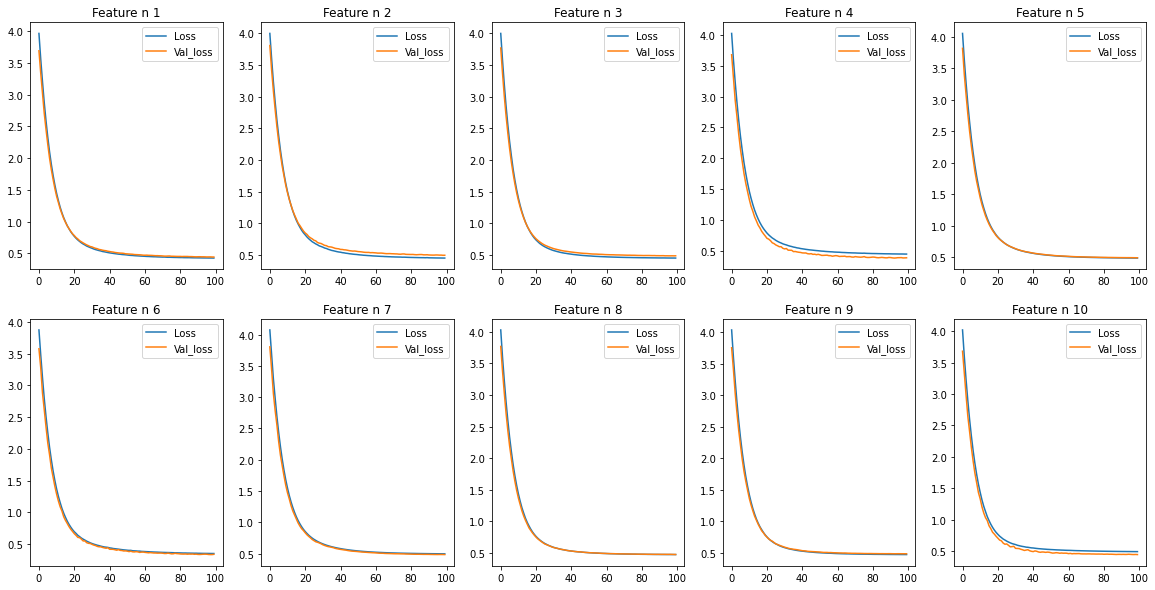

In [108]:
def plot_multi_loss(history_list):
  fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
  for i in range(2):
    for j in range(5):
      num_feature = i*5+j+1 
      ax[i,j].plot(history_list[num_feature-1].epoch,history_list[num_feature-1].history['loss'])
      ax[i,j].plot(history_list[num_feature-1].epoch,history_list[num_feature-1].history['val_loss'])
      ax[i,j].legend(["Loss", "Val_loss"])
      ax[i,j].set_title("Feature n {}".format(num_feature))

plot_multi_loss(history_list)

#### Predictions

In [110]:

predictions = []

for i in range(10):
    predictions.append(models[i].predict(x_fake_test))
warnings.filterwarnings('ignore')

In [111]:
predicted = np.zeros((x_fake_test.shape))
for j in range(10):
    for i in range(x_fake_test.shape[0]):
        predicted[i,j] = np.average(np.arange(1, 6), weights=predictions[j][i])
        #predicted[i,j] = np.argmax(predictions[j][i])

In [112]:
# calculate the MSE and MAE on Test Set
test_mse_nn = ((predicted - x_real_test.to_numpy()) **2).mean()
test_mae_nn = (abs(predicted - x_real_test.to_numpy())).mean()
print(f"Neural Network approach: \n MSE metric: {test_mse_nn.round(3)} \n MAE metric: {test_mae_nn.round(3)}")

Neural Network approach: 
 MSE metric: 1.051 
 MAE metric: 0.839


| Model | MSE | MAE |
| --- | --- | --- |
| Naive approach (classification) | 1.37 | 0.82 |
| Gradient Boosting Regression | 1.65 | 0.90 |
| Neural Networks | 1.05 | 0.84 |

As for the classification models the best one in term of MSE are the Neural Networks.

## 4.3 - Modelling with TF-IDF preprocessing

In [ ]:
# TF-IDF transformation

def to_Tfidf(dataframe):
    n_rows, n_col = dataframe.shape
    dataframe_Tfidf = dataframe.copy()
    for row in range(n_rows):
        counter = dataframe.iloc[row,:].value_counts()
        for col in range(n_col):
            dataframe_Tfidf.iloc[row,col] = counter[dataframe.iloc[row,col]]
    for col in range(n_col):
        counter = dataframe.iloc[:,col].value_counts()
        for row in range(n_rows):
            dataframe_Tfidf.iloc[row,col] *= log10(n_rows/counter[dataframe.iloc[row,col]])
    return dataframe_Tfidf

x_fake_tfidf = to_Tfidf(x_fake)

x_fake_smalltrain_tfidf = x_fake_tfidf[index==0]
x_fake_val_tfidf = x_fake_tfidf[index==1]
x_fake_test_tfidf = x_fake_tfidf[index==2]

x_fake_train_tfidf = x_fake_tfidf[index!=2]

### Tree Based Regression TF-IDF

In [113]:
X_train = x_fake_train_tfidf

X_test = x_fake_test_tfidf
y_test = x_real_test
y_pred = pd.DataFrame(index=y_test.index)

# we need to fit one model for each q (question)
for q in range(p-1):

    print(f"Start with question {q+1}")

    # define the target question
    y_train = x_real_train.iloc[:,q]

    # define the model, random state for reproducibility
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

    # search for best configuration with cross validation
    search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=10, cv=3, verbose=0, n_jobs=1, return_train_score=True)
    search.fit(X_train, y_train)

    # best model found
    best_model_parameters = report_best_scores(search.cv_results_, 1)

    # fit best configuration model
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **best_model_parameters)
    xgb_model.fit(X_train, y_train)

    # predict and append the question
    y_column_pred = xgb_model.predict(X_test)
    y_pred = y_pred.join(pd.Series(y_column_pred, index=y_test.index, name=y_test.columns[q]))

Start with question 1
Start with question 2
Start with question 3
Start with question 4
Start with question 5
Start with question 6
Start with question 7
Start with question 8
Start with question 9
Start with question 10


In [114]:
# calculate the MSE and MAE on Test Set
test_mse_xgboost_reg = ((y_pred.to_numpy().round(0) - y_test.to_numpy()) **2).mean()
test_mae_xgboost_reg = (abs(y_pred.to_numpy().round(0)- y_test.to_numpy())).mean()
print(f"XGBoost regression approach: \n MSE metric: {test_mse_xgboost_reg.round(3)} \n MAE metric: {test_mae_xgboost_reg.round(3)}")

XGBoost regression approach: 
 MSE metric: 1.079 
 MAE metric: 0.774


### ElasticNet Regression TF-IDF

In [115]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings('ignore')

# grid search to tune the parameters:
parametersGrid = {"max_iter": [1,10,100,1000], "alpha": [0.001, 0.01, 0.1, 1],"l1_ratio": np.arange(0.0, 1.0, 0.1)}

In [116]:
y_pred = pd.DataFrame(index=y_test.index)

# we need to fit one model for each q (question)
for q in range(p-1):

    print(f"Start with question {q+1}")

    # define the target question
    y_train = x_real_train.iloc[:,q]

    # define the model, random state for reproducibility
    eNet = ElasticNet(random_state=42)

    # search for best configuration with cross validation
    grid = GridSearchCV(eNet, parametersGrid, cv=5)
    grid.fit(X_train, y_train)

    # best model found
    best_model_parameters = report_best_scores(grid.cv_results_, 1)

    # fit best configuration model
    eNet = ElasticNet(random_state=42, **best_model_parameters)
    eNet.fit(X_train, y_train)

    # predict and append the question
    y_column_pred = eNet.predict(X_test)
    y_pred = y_pred.join(pd.Series(y_column_pred, index=y_test.index, name=y_test.columns[q]))

Start with question 1
Start with question 2
Start with question 3
Start with question 4
Start with question 5
Start with question 6
Start with question 7
Start with question 8
Start with question 9
Start with question 10


In [117]:
# calculate the MSE and MAE on Test Set
test_mse_elasticnet = ((y_pred.to_numpy() - y_test.to_numpy()) **2).mean()
test_mae_elasticnet = (abs(y_pred.to_numpy() - y_test.to_numpy())).mean()
print(f"ElasticNet regression approach: \n MSE metric: {test_mse_elasticnet.round(3)} \n MAE metric: {test_mae_elasticnet.round(3)}")

ElasticNet regression approach: 
 MSE metric: 1.025 
 MAE metric: 0.817


### Gradient Boosting Classification TF-IDF

In [118]:
X_train = x_fake_train_tfidf

X_test = x_fake_test_tfidf
y_test = x_real_test
y_pred = pd.DataFrame(index=y_test.index)

# we need to fit one model for each q (question)
for q in range(p-1):

    print(f"Start with question {q+1}")

    # define the target question
    y_train = x_real_train.iloc[:,q]

    # define the model, random state for reproducibility
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", num_parallel_tree = 3, eval_metric= "merror",  random_state=42)

    # search for best configuration with cross validation
    search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=10, cv=3, verbose=0, n_jobs=1, return_train_score=True)
    search.fit(X_train, y_train)

    # best model found
    best_model_parameters = report_best_scores(search.cv_results_, 1)

    # fit best configuration model
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, num_parallel_tree = 3,eval_metric= "merror",  **best_model_parameters)
    xgb_model.fit(X_train, y_train)

    # predict and append the question
    y_column_pred = xgb_model.predict(X_test)
    y_pred = y_pred.join(pd.Series(y_column_pred, index=y_test.index, name=y_test.columns[q]))

Start with question 1
Start with question 2
Start with question 3
Start with question 4
Start with question 5
Start with question 6
Start with question 7
Start with question 8
Start with question 9
Start with question 10


In [119]:
# calculate the MSE and MAE on Test Set
test_mse_xgboost_class = ((y_pred.to_numpy()- y_test.to_numpy()) **2).mean()
test_mae_xgboost_class = (abs(y_pred.to_numpy()- y_test.to_numpy())).mean()
print(f"XGBoost classification approach: \n MSE metric: {test_mse_xgboost_class.round(3)} \n MAE metric: {test_mae_xgboost_class.round(3)}")

XGBoost classification approach: 
 MSE metric: 1.6 
 MAE metric: 0.926


### Neural Network for classification TF-IDF

In [120]:
models = []
for i in range(10):
    models.append(tf.keras.models.Sequential([
                  tf.keras.layers.InputLayer((10,)),
                  tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                  tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                  tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                  tf.keras.layers.Dense(5, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))
]))

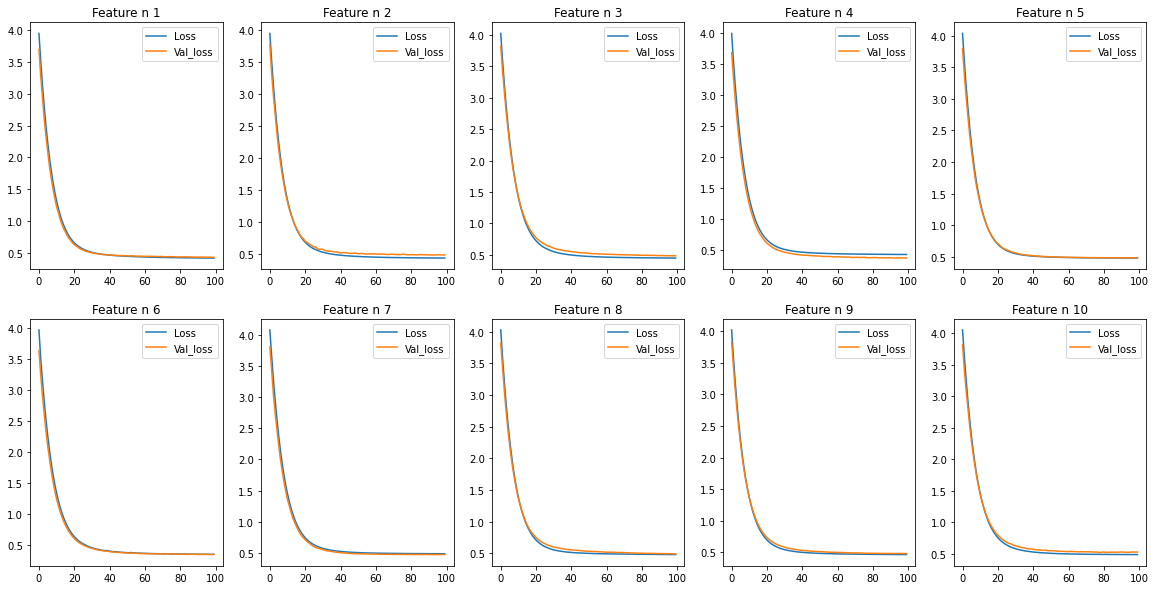

In [121]:
tf.random.set_seed(42)

history_list = []
for (i, model) in enumerate(models):
    model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=["accuracy"])
    history = model.fit(x_fake_smalltrain_tfidf, x_real_smalltrain_encoded[i], epochs=100,
                    validation_data=(x_fake_val_tfidf, x_real_val_encoded[i]), verbose = False)
    history_list.append(history)

plot_multi_loss(history_list)

In [125]:
predictions = []

for i in range(10):
    predictions.append(models[i].predict(x_fake_test_tfidf))

warnings.filterwarnings('ignore')

In [123]:
predicted = np.zeros((x_fake_test_tfidf.shape))
for j in range(10):
    for i in range(x_fake_test_tfidf.shape[0]):
        predicted[i,j] = np.average(np.arange(1, 6), weights=predictions[j][i])
        #predicted[i,j] = np.argmax(predictions[j][i])

In [124]:
# calculate the MSE and MAE on Test Set
test_mse_nn = ((predicted - x_real_test.to_numpy()) **2).mean()
test_mae_nn = (abs(predicted - x_real_test.to_numpy())).mean()
print(f"Neural Network approach: \n MSE metric: {test_mse_nn.round(3)} \n MAE metric: {test_mae_nn.round(3)}")

Neural Network approach: 
 MSE metric: 1.06 
 MAE metric: 0.839


| Model | MSE | MAE |
| --- | --- | --- |
| Gradient Boosting Regression TF-IDF | 1.08 | 0.77 |
| ElasticNet Regression TF-IDF| 1.03 | 0.82 |
| Classification Tree TF-IDF | 1.60 | 0.93 |
| Neural Networks TF-IDF| 1.06 | 0.84 |

The TF-IDF approach doesn't change remarkably with respect to the performances obtained with the original data.

## 5 - Overall comparison of models

| Model | MSE | MAE |
| --- | --- | --- |
| Naive approach | 1.29 | 0.84 |
| | | |
| Denoising Autoencoder | 1.13 | 0.83 |
| **Gradient Boosting Regression** | 1.12 | **0.77** |
| ElasticNet Regression | 1.05 | 0.81 |
|  | ||
| Classification Tree | 1.65 | 0.90 |
| Neural Networks | 1.05 | 0.84 |
|  |  | |
| **Gradient Boosting Regression TF-IDF** | 1.08 | **0.77** |
| **ElasticNet Regression TF-IDF**| **1.03** | 0.82 |
| Classification Tree TF-IDF | 1.60 | 0.93 |
| Neural Networks TF-IDF| 1.06 | 0.84 |